In [1]:
!pip install contractions

     |████████████████████████████████| 327kB 39.0MB/s 
     |████████████████████████████████| 286kB 24.5MB/s 
  Created wheel for pyahocorasick: filename=pyahocorasick-1.4.2-cp37-cp37m-linux_x86_64.whl size=85395 sha256=468a0f306a82d61ec2a0d831cc8f9503736ab5d3af2bf7d8cf8999b4fce86b67
  Stored in directory: /root/.cache/pip/wheels/3a/03/34/77e3ece0bba8b86bfac88a79f923b36d805cad63caeba38842
Successfully built pyahocorasick


In [2]:
import numpy as np
import pandas as pd
from collections import Counter

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(color_codes=True)
import missingno
from wordcloud import WordCloud, ImageColorGenerator


import os
import string
import re
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
import contractions

import tensorflow
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Embedding,LSTM,GRU,Bidirectional,BatchNormalization,Dropout
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau

import warnings
warnings.filterwarnings("ignore")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [3]:
data_path_1 = '/content/drive/MyDrive/Untitled folder/Sarcasm_Headlines_Dataset.json'
data_path_2 = '/content/drive/MyDrive/Untitled folder/Sarcasm_Headlines_Dataset_v2.json'
data_path_3 = '/content/drive/MyDrive/Untitled folder/sarcasm_tweets.txt'
data_path_4 = '/content/drive/MyDrive/Untitled folder/nonsarcasm_tweets.txt'
data_path_5 = '/content/drive/MyDrive/Untitled folder/English Sarcasm.csv'
data_path_6 = '/content/drive/MyDrive/Untitled folder/train.csv'

df1 = pd.read_json(data_path_1,lines=True)
df1.drop('article_link',axis=1,inplace=True)

df2 = pd.read_json(data_path_2,lines=True)
df2.drop('article_link',axis=1,inplace=True)

with open(data_path_3) as f:
    lines = f.readlines()
lines = [l.strip() for l in lines]
df3 = pd.DataFrame()
df3['headline'] = lines
df3['is_sarcastic'] = 1

with open(data_path_4) as f:
    lines = f.readlines()
lines = [l.strip() for l in lines]
df4 = pd.DataFrame()
df4['headline'] = lines
df4['is_sarcastic'] = 0

df5 = pd.read_csv(data_path_5)
df5.columns = ['headline','is_sarcastic']

df6 = pd.read_csv(data_path_6)
df_ = df6[df6['class'] == 'sarcasm']
df__ = df6[df6['class'] == 'regular']
df_.drop('class' , axis = 1 , inplace = True)
df__.drop('class' , axis = 1 , inplace = True)
df_['class'] = 1
df__['class'] = 0
df6 = pd.concat([df_,df__])
df6.columns = ['headline','is_sarcastic']

data = pd.concat([df1,df2,df3,df4,df5,df6])
df = data.copy()

df.head()

,headline,is_sarcastic
0,former versace store clerk sues over secret 'b...,0
1,the 'roseanne' revival catches up to our thorn...,0
2,mom starting to fear son's web series closest ...,1
3,"boehner just wants wife to listen, not come up...",1
4,j.k. rowling wishes snape happy birthday in th...,0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 104311 entries, 0 to 60726
Data columns (total 2 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   headline      104311 non-null  object
 1   is_sarcastic  104311 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ MB


In [5]:
df.shape

(104311, 2)

Missing Data
headline        0
is_sarcastic    0
dtype: int64



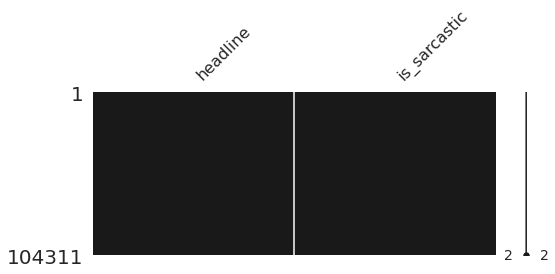

In [6]:
missingno.matrix(df,figsize=(8,3) , color = (0.1,0.1,0.1))
print('Missing Data')
print(df.isnull().sum())
print()

In [7]:
def df_analysis(col) :
    df['num_chars'] = df[col].apply(lambda x : len(str(x)))
    df['num_words'] = df[col].apply(lambda x : len(str(x).split()))
    df['num_sents'] = df[col].apply(lambda x : len([i for i in re.split('\\.|\n',x) if len(i) > 1]))
    df['num_unique_words'] = df[col].apply(lambda x : len(set(str(x).split())))
    df['num_stopwords'] = df[col].apply(lambda x : len(list(set(str(x).lower().split()).difference(stopwords.words('english')))))
    df['num_punct'] = df[col].apply(lambda x : len([i for i in str(x) if i in string.punctuation]))
    df['mean_word_length'] = df[col].apply(lambda x : np.mean([len(i) for i in str(x).split()]))
    df['num_urls'] = df[col].apply(lambda x : len([i for i in str(x).lower().split() if 'http' in i or 'https' in i]))
    df['num_#'] = df[col].apply(lambda x: len([i for i in str(x) if i == '#']))
    df['num_@'] = df[col].apply(lambda x: len([i for i in str(x) if i == '@']))
    emoji = re.compile("["
                           u"\U0001F600-\U0001FFFF" 
                           u"\U0001F300-\U0001F5FF"  
                           u"\U0001F680-\U0001F6FF"  
                           u"\U0001F1E0-\U0001F1FF" 
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    df['num_emoji_symbols_etc'] = df[col].apply(lambda x : len(emoji.findall(x)))
    return df

In [8]:
df = df_analysis('headline')

In [9]:
df.head()

,headline,is_sarcastic,num_chars,num_words,num_sents,num_unique_words,num_stopwords,num_punct,mean_word_length,num_urls,num_#,num_@,num_emoji_symbols_etc
0,former versace store clerk sues over secret 'b...,0,78,12,1,12,10,2,5.583333,0,0,0,0
1,the 'roseanne' revival catches up to our thorn...,0,84,14,1,14,8,3,5.071429,0,0,0,0
2,mom starting to fear son's web series closest ...,1,79,14,1,13,9,1,4.714286,0,0,0,0
3,"boehner just wants wife to listen, not come up...",1,84,13,1,13,8,2,5.538462,0,0,0,0
4,j.k. rowling wishes snape happy birthday in th...,0,64,11,1,11,8,2,4.909091,0,0,0,0


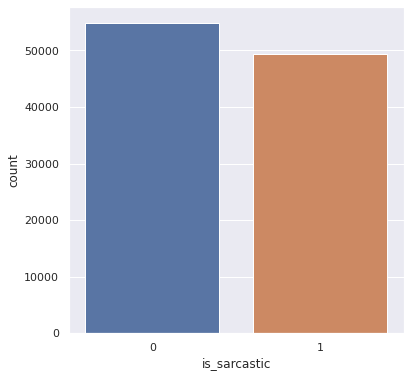

In [10]:
plt.figure(figsize=(6,6))
sns.countplot(df['is_sarcastic'])

In [13]:
def plot_analysis(df , group_col , cols) :
    for col in cols :
        mean = df.groupby(group_col)[col].mean()
        plt.figure(figsize=(16,4))
        plt.subplot(1, 3, 1)
        sns.violinplot(x=group_col,y=col,data=df)
        plt.tight_layout()
        plt.subplot(1, 3, 2)
        sns.barplot(x=mean.index,y=mean.values)
        plt.tight_layout()
        plt.title(f'{col.upper()} ANALYSIS')
        plt.subplot(1, 3, 3)
        sns.kdeplot(x=col,shade=True,data=df,hue=group_col)
        plt.tight_layout()

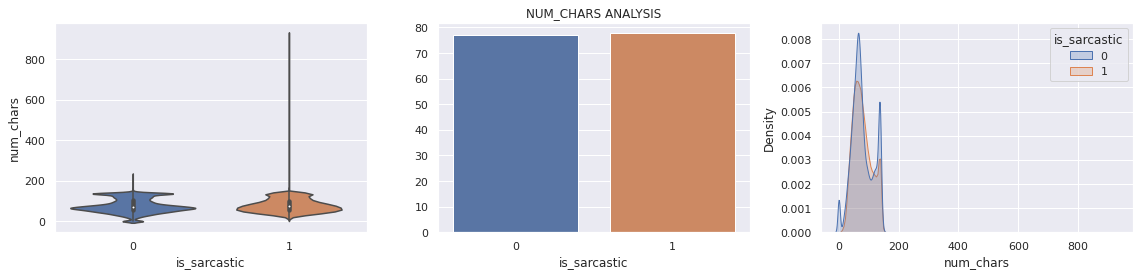

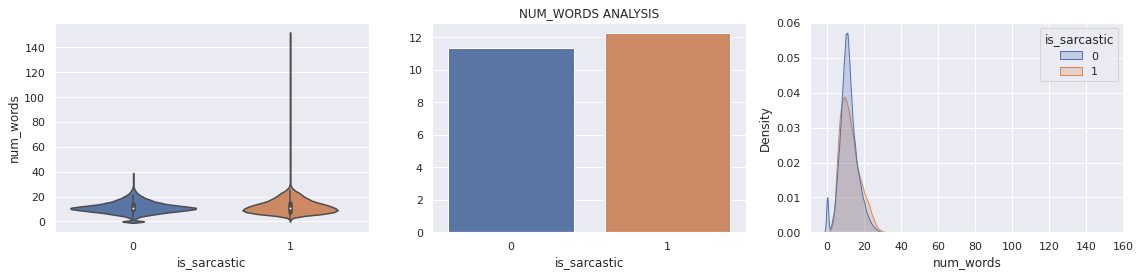

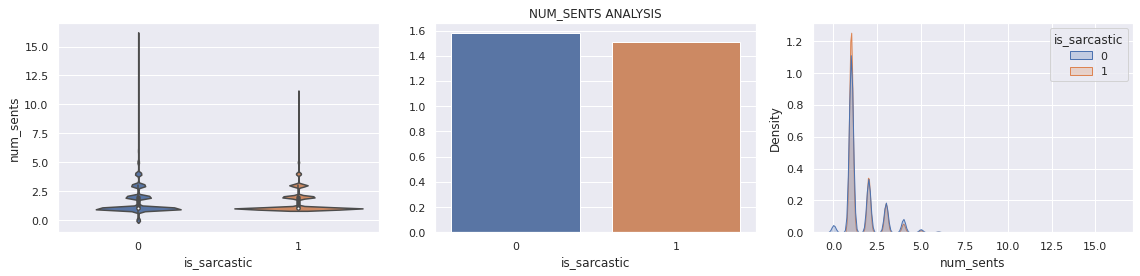

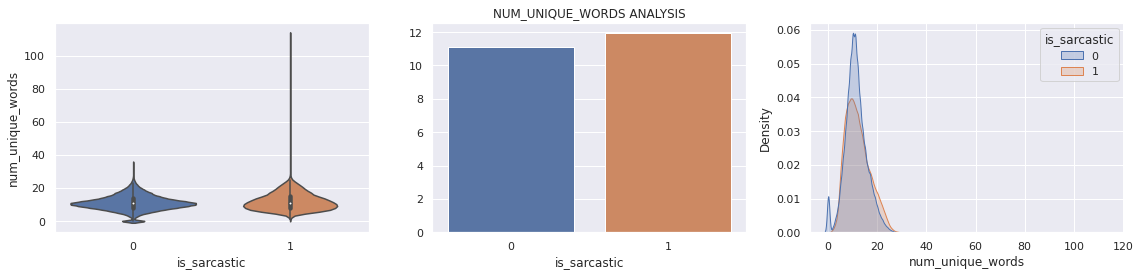

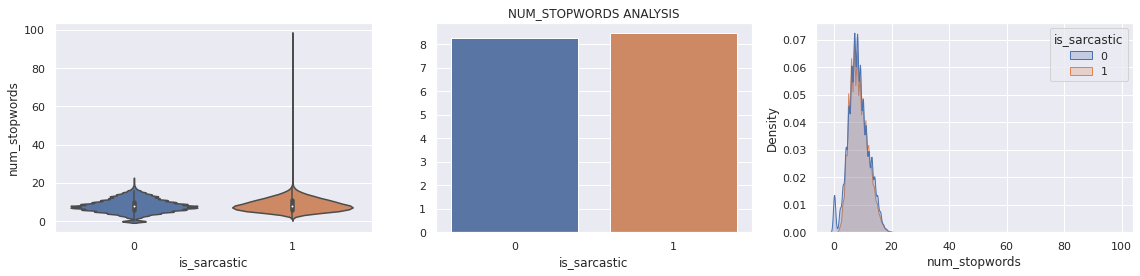

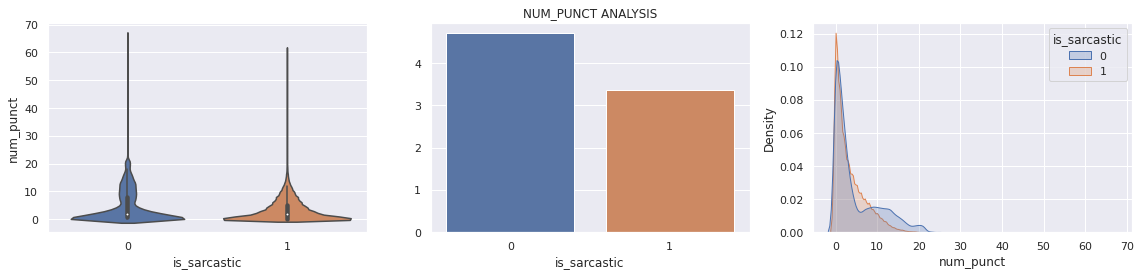

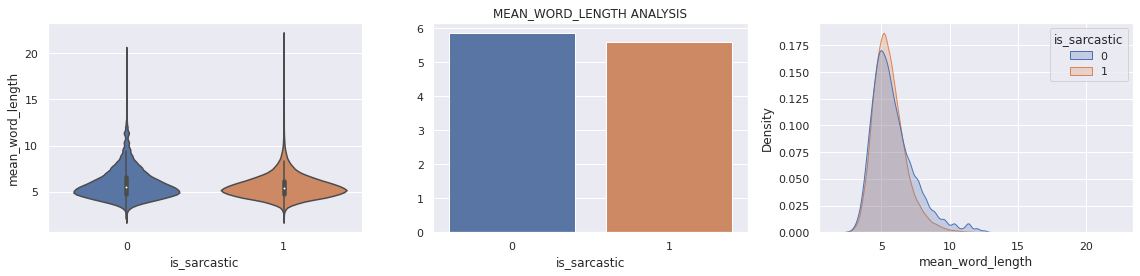

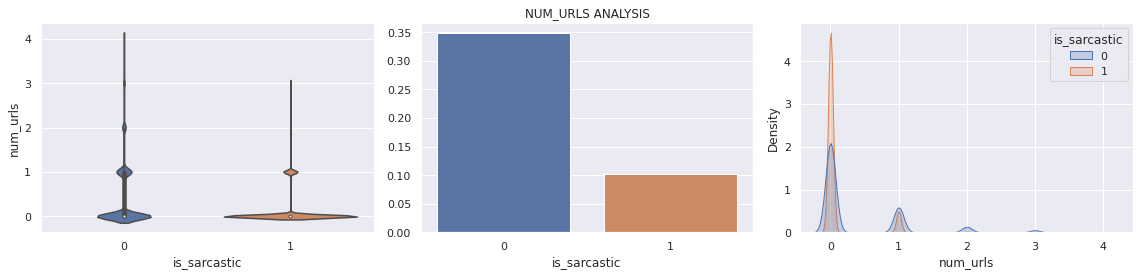

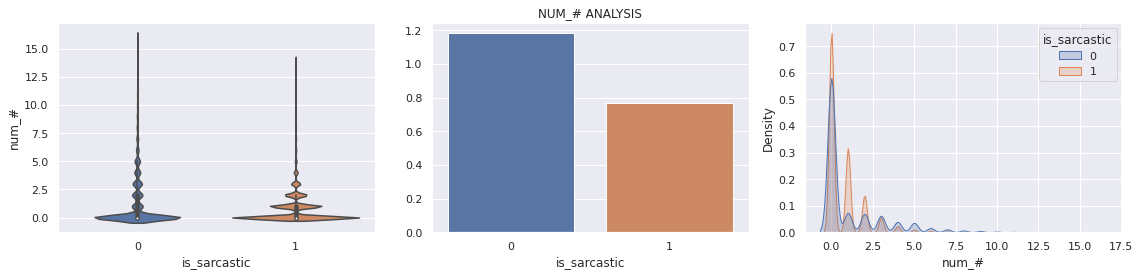

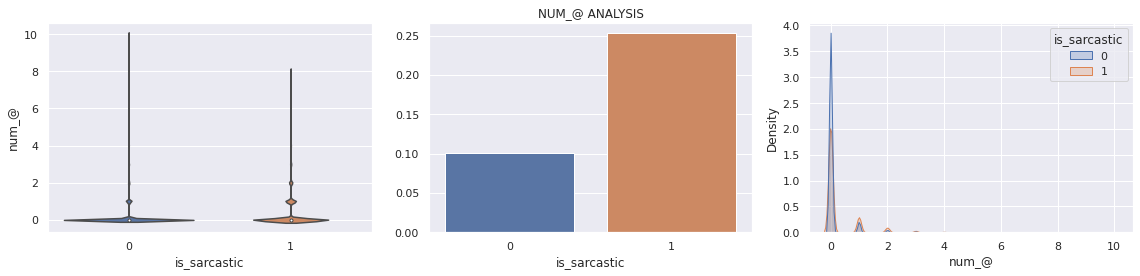

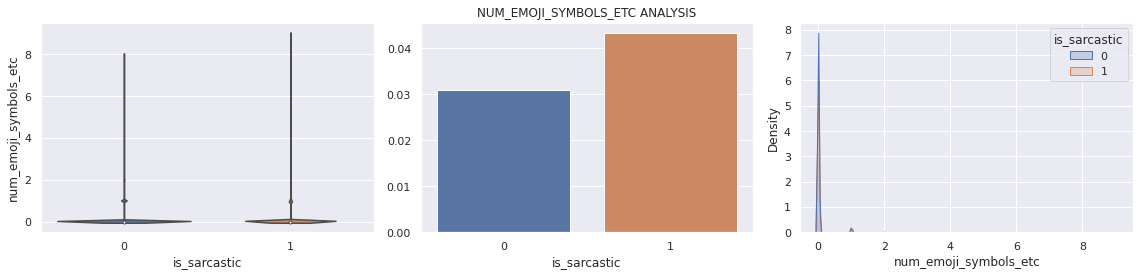

In [14]:
c = ['num_chars', 'num_words','num_sents', 'num_unique_words', 
     'num_stopwords', 'num_punct','mean_word_length', 'num_urls', 
     'num_#', 'num_@','num_emoji_symbols_etc']
plot_analysis(df,'is_sarcastic', c)

In [15]:
def text_preprocessing(content) :
    corpus = []
    for line in content :
        text = line.lower()
        pattern = re.compile('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')
        text = pattern.sub('', text)
        text = " ".join(filter(lambda x:x[0]!='@', text.split()))
        emoji = re.compile("["u"\U0001F600-\U0001FFFF" u"\U0001F300-\U0001F5FF" u"\U0001F680-\U0001F6FF"   
                              u"\U0001F1E0-\U0001F1FF" u"\U00002702-\U000027B0" u"\U000024C2-\U0001F251"
                            "]+", flags=re.UNICODE)     
        text = emoji.sub(r'', text)
        text = text.lower()
        text = ' '.join([contractions.fix(word) for word in text.split()])
        text = text.lower()
        text = re.sub(r"\'ve", " have", text)  
        text = re.sub(r"did't", "did not", text)
        text = re.sub(r"have't", "have not", text)
        text = re.sub(r"[,.\"\'!@#$%^&*(){}?/;`~:<>+=-]", "", text)
        tokens = word_tokenize(text)
        table = str.maketrans('', '', string.punctuation)
        stripped = [w.translate(table) for w in tokens]
        words = [word for word in stripped if word.isalpha()]
        stop_words = set(stopwords.words("english"))
        words = [w.strip() for w in words if not w in stop_words]
        lemma = WordNetLemmatizer()
        words = [lemma.lemmatize(w) for w in words]
        corpus.append(words)
    return corpus

In [16]:
content = df['headline'].values.tolist()
corpus = text_preprocessing(content)

In [17]:
corpus[:5]

[['former',
  'versace',
  'store',
  'clerk',
  'sue',
  'secret',
  'black',
  'code',
  'minority',
  'shopper'],
 ['roseanne',
  'revival',
  'catch',
  'thorny',
  'political',
  'mood',
  'better',
  'worse'],
 ['mom',
  'starting',
  'fear',
  'son',
  'web',
  'series',
  'closest',
  'thing',
  'grandchild'],
 ['boehner',
  'want',
  'wife',
  'listen',
  'come',
  'alternative',
  'debtreduction',
  'idea'],
 ['jk', 'rowling', 'wish', 'snape', 'happy', 'birthday', 'magical', 'way']]

In [18]:
def plot_wordcloud(corp_col , corp_val , text_col , title) :
    pos_data = df.loc[data[corp_col] == corp_val]
    pos_head_lines = text_preprocessing(pos_data[text_col].values.tolist())
    pos_lines = [j for sub in pos_head_lines for j in sub] 
    word_could_dict=Counter(pos_lines)

    wordcloud = WordCloud(width = 1000, height = 500).generate_from_frequencies(word_could_dict)
    plt.figure(figsize=(20,10))
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.title(title)

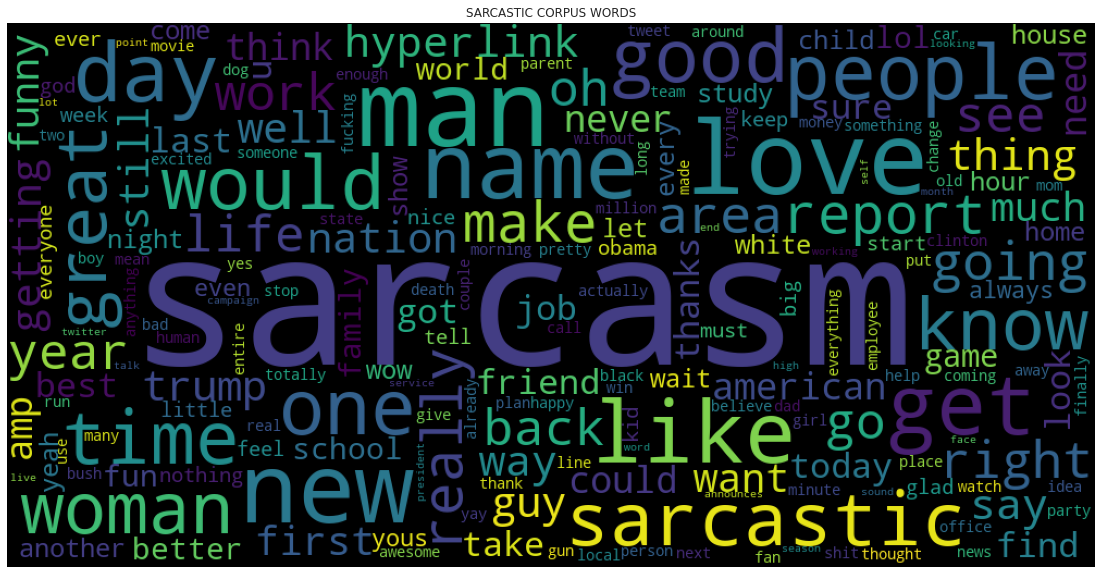

In [19]:
plot_wordcloud(
    corp_col = 'is_sarcastic' ,
    corp_val = 1 ,
    text_col = 'headline' ,
    title = 'SARCASTIC CORPUS WORDS'
)

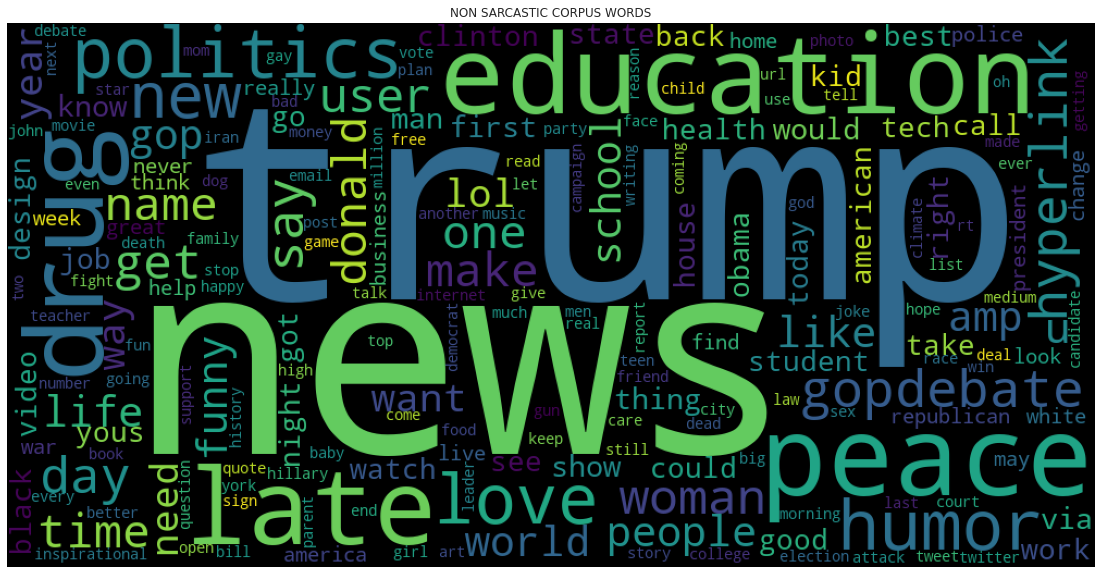

In [20]:
plot_wordcloud(
    corp_col = 'is_sarcastic' ,
    corp_val = 0 ,
    text_col = 'headline' ,
    title = 'NON SARCASTIC CORPUS WORDS'
)

In [21]:
val_split = 0.2
max_len = 30
categories = df['is_sarcastic'].values

tokenizer = Tokenizer()
tokenizer.fit_on_texts(corpus)
sequences = tokenizer.texts_to_sequences(corpus)

word_index = tokenizer.word_index
print("unique tokens - "+str(len(word_index)))
vocab_size = len(tokenizer.word_index) + 1
print('vocab_size - '+str(vocab_size))

lines_pad = pad_sequences(sequences, maxlen=max_len, padding='post')

indices = np.arange(lines_pad.shape[0])
np.random.shuffle(indices)
lines_pad = lines_pad[indices]
categories = categories[indices]

num_validation_samples = int(val_split * lines_pad.shape[0])

x_train = lines_pad[:-num_validation_samples]
y_train = categories[:-num_validation_samples]
x_test = lines_pad[-num_validation_samples:]
y_test = categories[-num_validation_samples:]


print('\nShape of x_train:', x_train.shape)
print('Shape of y_train:', y_train.shape)

print('\nShape of x_test:', x_test.shape)
print('Shape of y_test:', y_test.shape)

unique tokens - 56414
vocab_size - 56415

Shape of x_train: (83449, 30)
Shape of y_train: (83449,)

Shape of x_test: (20862, 30)
Shape of y_test: (20862,)


In [22]:
embeddings_index = {}

f = open('/content/drive/MyDrive/Embeddings/glove.840B.300d.txt')
for line in f:
    values = line.split(' ')
    word = values[0] 
    coefs = np.asarray(values[1:], dtype='float32') 
    embeddings_index[word] = coefs
f.close()

print('GloVe data loaded')
print(f'Found {str(len(embeddings_index))} word vectors.')

GloVe data loaded
Found 2196017 word vectors.


In [23]:
embedding_dim = 300
embedding_matrix = np.zeros((len(word_index) + 1, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

embedding_layer = Embedding(len(word_index) + 1,
                            embedding_dim,
                            weights=[embedding_matrix],
                            input_length=max_len,
                            trainable=False)

In [24]:
model = Sequential()
model.add(embedding_layer)
model.add(Bidirectional(GRU(units=64)))
model.add(Dropout(0.5))
model.add(BatchNormalization())
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adamax', metrics=['accuracy'])

print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 30, 300)           16924500  
_________________________________________________________________
bidirectional (Bidirectional (None, 128)               140544    
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
batch_normalization (BatchNo (None, 128)               512       
_________________________________________________________________
dense (Dense)                (None, 1)                 129       
Total params: 17,065,685
Trainable params: 140,929
Non-trainable params: 16,924,756
_________________________________________________________________
None


In [25]:
es = EarlyStopping(monitor = 'val_loss' , mode = 'min' , verbose = 1 , patience = 3)
rlr = ReduceLROnPlateau(monitor = 'val_accuracy', patience = 2 , verbose = 1 , factor = 0.5 , min_lr = 0.0000001)

callbacks = [es,rlr]

In [26]:
history = model.fit(x_train, y_train, batch_size=64, epochs=30, validation_data=(x_test, y_test), callbacks=callbacks, verbose=1)

Epoch 1/30
1304/1304 [==============================] - 46s 9ms/step - loss: 0.4595 - accuracy: 0.7687 - val_loss: 0.3062 - val_accuracy: 0.8576
Epoch 2/30
1304/1304 [==============================] - 11s 8ms/step - loss: 0.3011 - accuracy: 0.8635 - val_loss: 0.2799 - val_accuracy: 0.8735
Epoch 3/30
1304/1304 [==============================] - 11s 8ms/step - loss: 0.2542 - accuracy: 0.8907 - val_loss: 0.2670 - val_accuracy: 0.8820
Epoch 4/30
1304/1304 [==============================] - 11s 8ms/step - loss: 0.2300 - accuracy: 0.9030 - val_loss: 0.2375 - val_accuracy: 0.8994
Epoch 5/30
1304/1304 [==============================] - 11s 8ms/step - loss: 0.2061 - accuracy: 0.9157 - val_loss: 0.2383 - val_accuracy: 0.8991
Epoch 6/30
1304/1304 [==============================] - 11s 8ms/step - loss: 0.1830 - accuracy: 0.9254 - val_loss: 0.2144 - val_accuracy: 0.9143
Epoch 7/30
1304/1304 [==============================] - 11s 8ms/step - loss: 0.1634 - accuracy: 0.9348 - val_loss: 0.2120 - val_ac

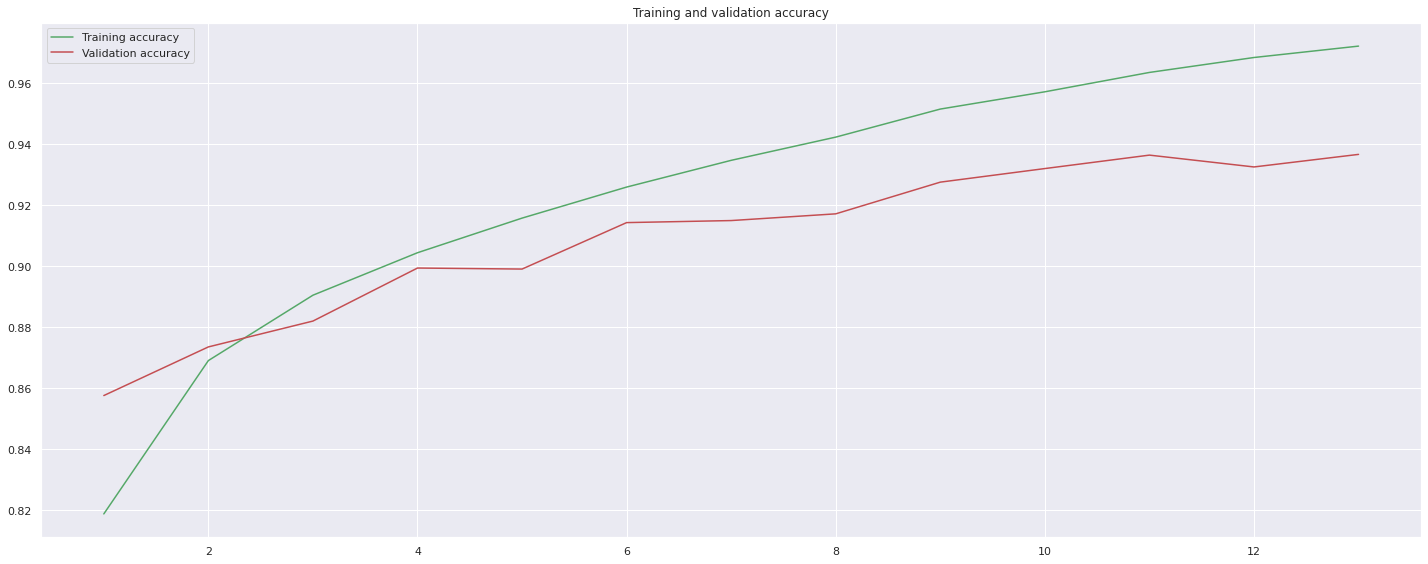

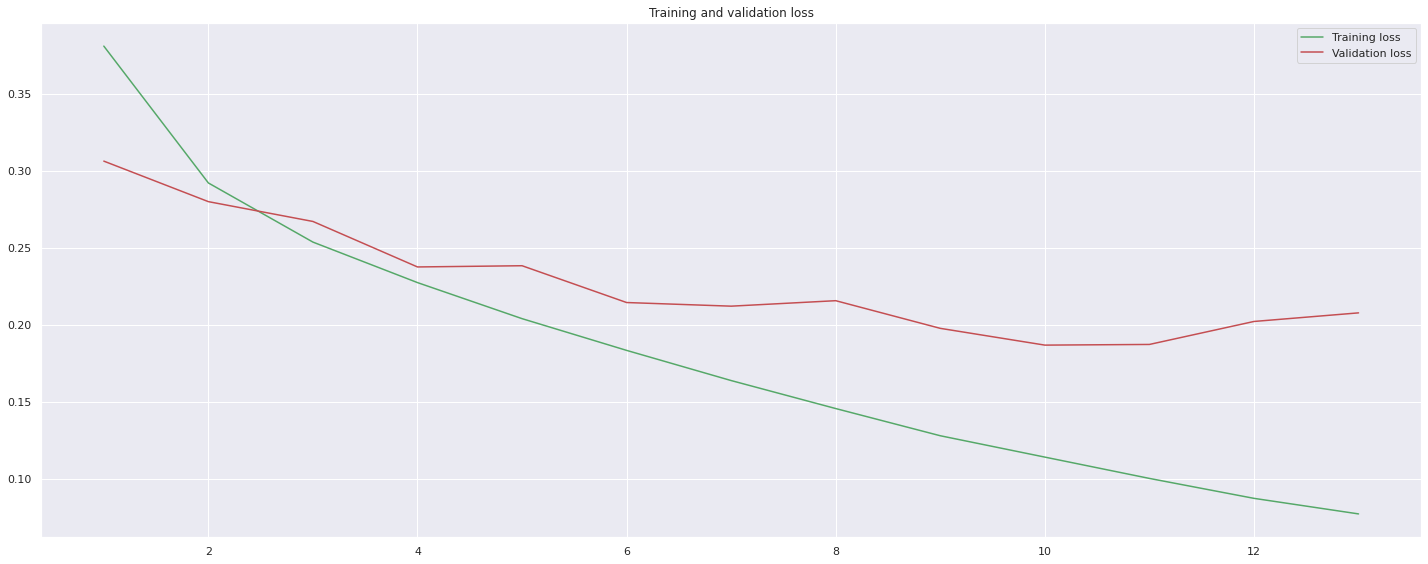

In [27]:
result = pd.DataFrame(history.history)

acc = result['accuracy']
val_acc = result['val_accuracy']
loss = result['loss']
val_loss = result['val_loss']

epochs = range(1, len(acc)+1)

plt.figure(figsize=(20,8))
plt.plot(epochs, acc, 'g', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.tight_layout()

plt.figure(figsize=(20,8))
plt.plot(epochs, loss, 'g', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.tight_layout()

plt.show()

In [28]:
def predict_sarcasm(s):
    x_final = [s]
    test_lines = text_preprocessing(x_final)
    test_sequences = tokenizer.texts_to_sequences(test_lines)
    test_review_pad = pad_sequences(test_sequences, maxlen=max_len, padding='post')
    pred = model.predict(test_review_pad)
    pred*=100
    if pred[0][0]>=50: return "It's a sarcasm!" 
    else: return "It's not a sarcasm."

In [29]:
test_lines = [
      ("I was depressed. He asked me to be happy. I am not depressed anymore." , "It's a sarcasm!") ,
      ("You just broke my car window. Great job." , "It's a sarcasm!") ,
      ("You just saved my dog's life. Thanks a million." , "It's not a sarcasm.") ,
      ("I want a million dollars!" , "It's not a sarcasm.") ,
      ("I just won a million dollars!" , "It's a sarcasm!") ,
      ("His name is Bob. He is a nice person." , "It's not a sarcasm.") ,
      ("Sarcasm is very easy to detect." , "It's a sarcasm!") 
]

In [30]:
correct_count = 0
for line in test_lines :
    x = line[0]
    y = line[1]
    y_pred = predict_sarcasm(x)
    print(f'Input : {x}')
    print(f'Actual : {y}    Predicted : {y_pred}')
    print()
    if y == y_pred :
        correct_count += 1
print(f'Accuracy : {np.round((correct_count / len(test_lines))*100 , 2 )}')

Input : I was depressed. He asked me to be happy. I am not depressed anymore.
Actual : It's a sarcasm!    Predicted : It's a sarcasm!

Input : You just broke my car window. Great job.
Actual : It's a sarcasm!    Predicted : It's a sarcasm!

Input : You just saved my dog's life. Thanks a million.
Actual : It's not a sarcasm.    Predicted : It's not a sarcasm.

Input : I want a million dollars!
Actual : It's not a sarcasm.    Predicted : It's not a sarcasm.

Input : I just won a million dollars!
Actual : It's a sarcasm!    Predicted : It's a sarcasm!

Input : His name is Bob. He is a nice person.
Actual : It's not a sarcasm.    Predicted : It's a sarcasm!

Input : Sarcasm is very easy to detect.
Actual : It's a sarcasm!    Predicted : It's a sarcasm!

Accuracy : 85.71
